In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
from sklearn import preprocessing as pre

from scipy.interpolate import make_interp_spline
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/physio_biodiv.csv')
df

,time,Pvar,Pdiv,AreaSedCover,Plant,AngioGymno
0,-541.0,0.165733,0.491878,3.201743e+05,0.000000,0.000000
1,-540.0,0.162762,0.526029,3.432611e+05,0.000000,0.000000
2,-539.0,0.160894,0.548926,3.702218e+05,0.000000,0.000000
3,-538.0,0.159962,0.562264,4.020043e+05,0.000000,0.000000
4,-537.0,0.159796,0.567736,4.395563e+05,0.000000,0.000000
...,...,...,...,...,...,...
537,-4.0,0.343036,0.606444,7.446228e+07,709.596322,635.964009
538,-3.0,0.349415,0.604458,7.396436e+07,714.520844,641.418280
539,-2.0,0.358138,0.601523,7.324326e+07,720.015654,646.807618
540,-1.0,0.368995,0.597677,7.224669e+07,727.367682,652.125148


In [3]:
df.corr()

,time,Pvar,Pdiv,AreaSedCover,Plant,AngioGymno
time,1.000000,0.780241,0.679156,0.954127,0.962364,0.934167
Pvar,0.780241,1.000000,0.213730,0.763103,0.817970,0.829107
Pdiv,0.679156,0.213730,1.000000,0.571353,0.563262,0.508684
AreaSedCover,0.954127,0.763103,0.571353,1.000000,0.932687,0.964018
Plant,0.962364,0.817970,0.563262,0.932687,1.000000,0.966300
AngioGymno,0.934167,0.829107,0.508684,0.964018,0.966300,1.000000


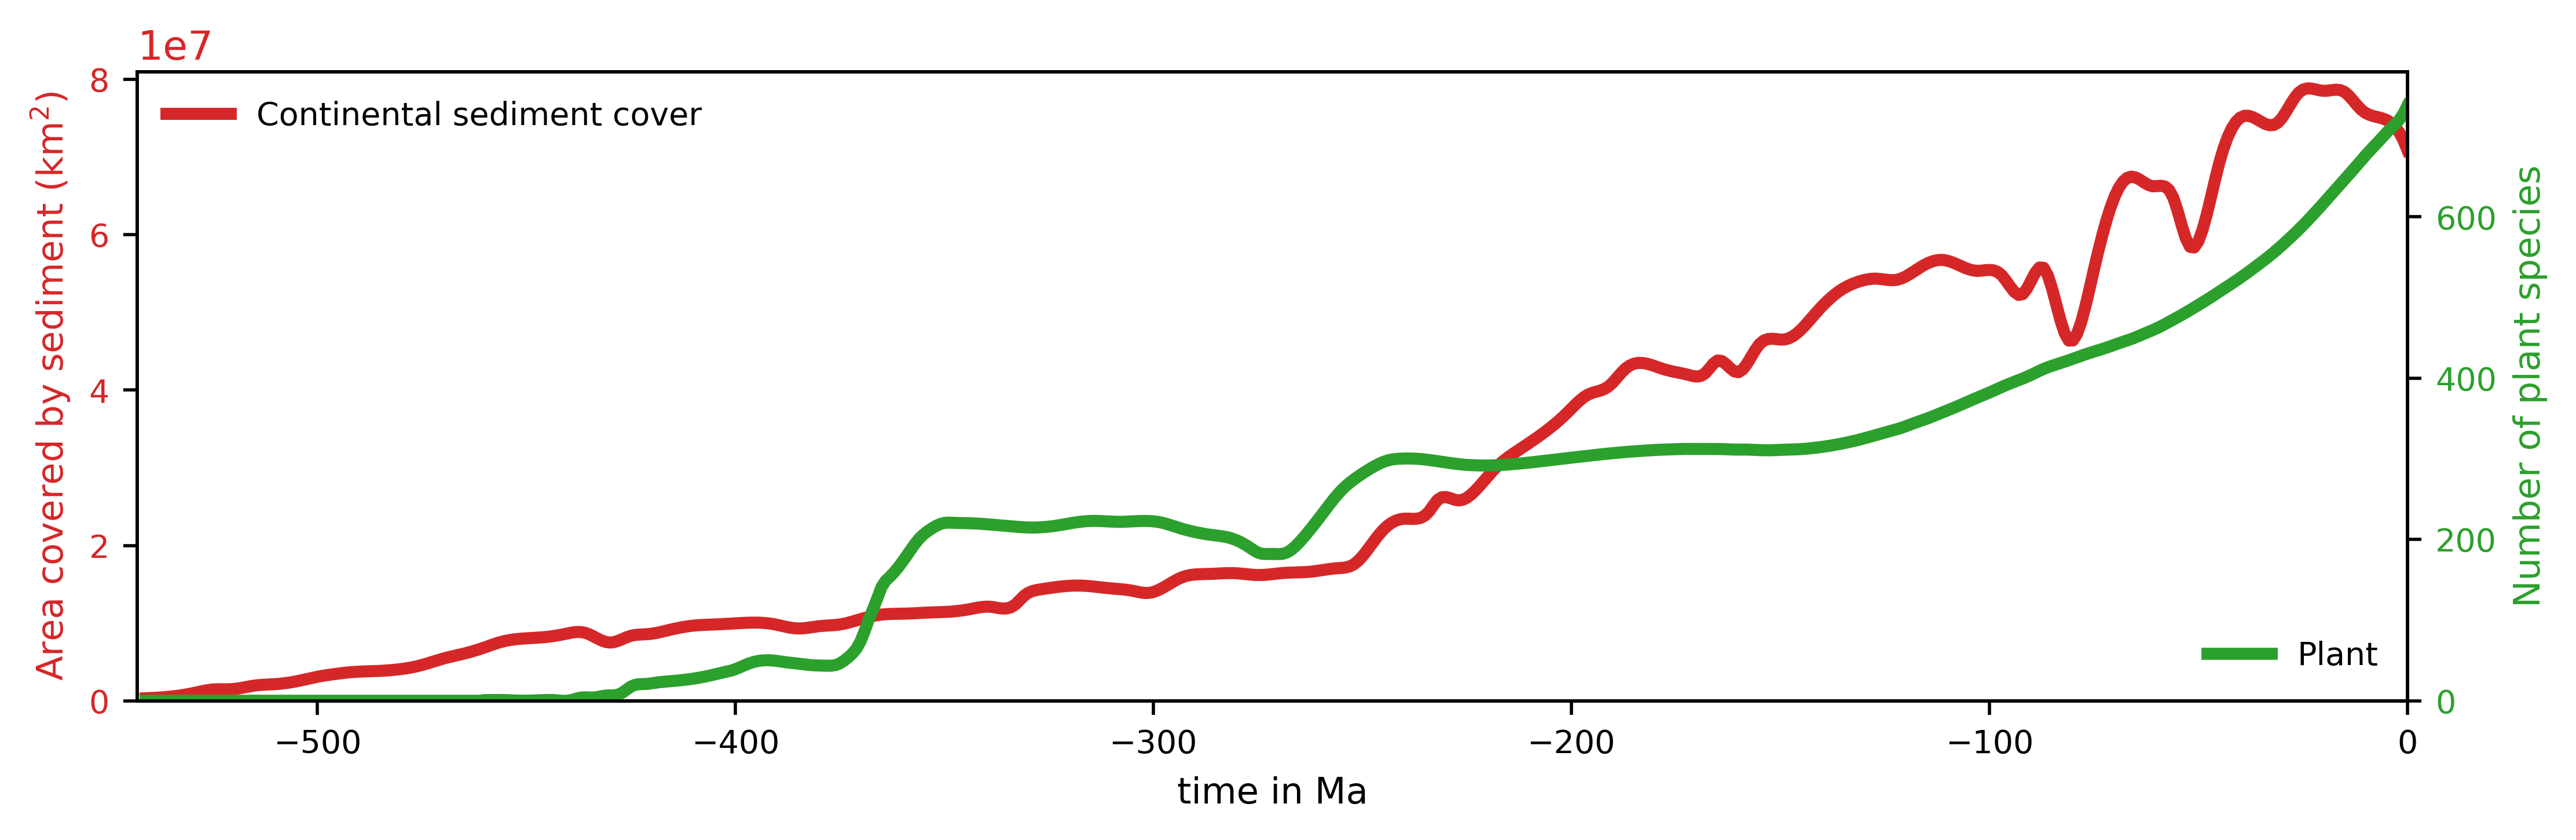

In [4]:
fig, ax1 = plt.subplots(figsize=(9, 3), dpi=500)
ax1.plot(df['time'], df['AreaSedCover'], '-', color='tab:red', zorder=2, lw=3, label='Continental sediment cover')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax1.tick_params(axis='y', labelcolor='tab:red')
plt.ylabel('Area covered by sediment (km$^2$)', fontsize=9, color='tab:red')
plt.xlabel('time in Ma', fontsize=9)
plt.xlim([-543,0])
plt.ylim([0,8.1e7])
plt.legend(frameon=False, prop={'size': 8}, loc=2)
         
ax2 = ax1.twinx()
ax2.plot(df['time'], df['Plant'], color='tab:green', lw=3, label='Plant')
plt.ylabel('Number of plant species', fontsize=9, color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([0,780])
plt.legend(frameon=False, prop={'size': 8}, loc=4)

fig.tight_layout()
# plt.savefig('trend_erodeprate.png',dpi=500,transparent=True)
plt.show()

In [5]:
# Dataset
area_Spline = make_interp_spline(df['time'].values, df['AreaSedCover'].values)
plant_Spline = make_interp_spline(df['time'].values, df['Plant'].values)
 
# Returns evenly spaced numbers over a specified interval.
tme = np.linspace(-450, 0, 451)
area = area_Spline(tme)
plant = plant_Spline(tme)

In [6]:
def getCorrelations(data1, data2):
    
    cpearson, _ = pearsonr(np.asarray(data1), np.asarray(data2))
    cspearman, _ = spearmanr(np.asarray(data1), np.asarray(data2))

    print('Pearsons correlation value: %.3f' % cpearson)
    print('Spearman correlation value: %.3f' % cspearman)

    return #cpearson, cspearman

getCorrelations(area, plant)

Pearsons correlation value: 0.915
Spearman correlation value: 0.977


In [7]:
# Save interpolated dataset
data = {'time (Ma)': tme,
        'Area (km2)': area,
        'bioPlant (Species Nb)': plant,
       }
sdf = pd.DataFrame(data)
sdf.to_csv('sedcover_vs_plantbio.csv', index = False)

## Combining physiography diversity and sediment cover

In [8]:
# with sklearn
regr = linear_model.LinearRegression()
x = df[['Pvar','AreaSedCover']]
y = df['Plant']

regr.fit(x, y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -83.02263688282153
Coefficients: 
 [6.86946073e+02 5.74754229e-06]


In [9]:
# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

In [10]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  Plant   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2345.
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.11e-266
Time:                        08:51:18   Log-Likelihood:                -2985.3
No. Observations:                 542   AIC:                             5977.
Df Residuals:                     539   BIC:                             5989.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -83.0226      9.840     -8.437   

In [11]:
print('Intercept: \n', regr.intercept_)
print('Coefficient Pvar: \n', regr.coef_[0])
print('Coefficient AreaSedCover: \n', regr.coef_[1])

plantValues = regr.intercept_ + df['Pvar'].values * regr.coef_[0] + df['AreaSedCover'].values * regr.coef_[1]

Intercept: 
 -83.02263688282153
Coefficient Pvar: 
 686.9460725827482
Coefficient AreaSedCover: 
 5.747542286039408e-06


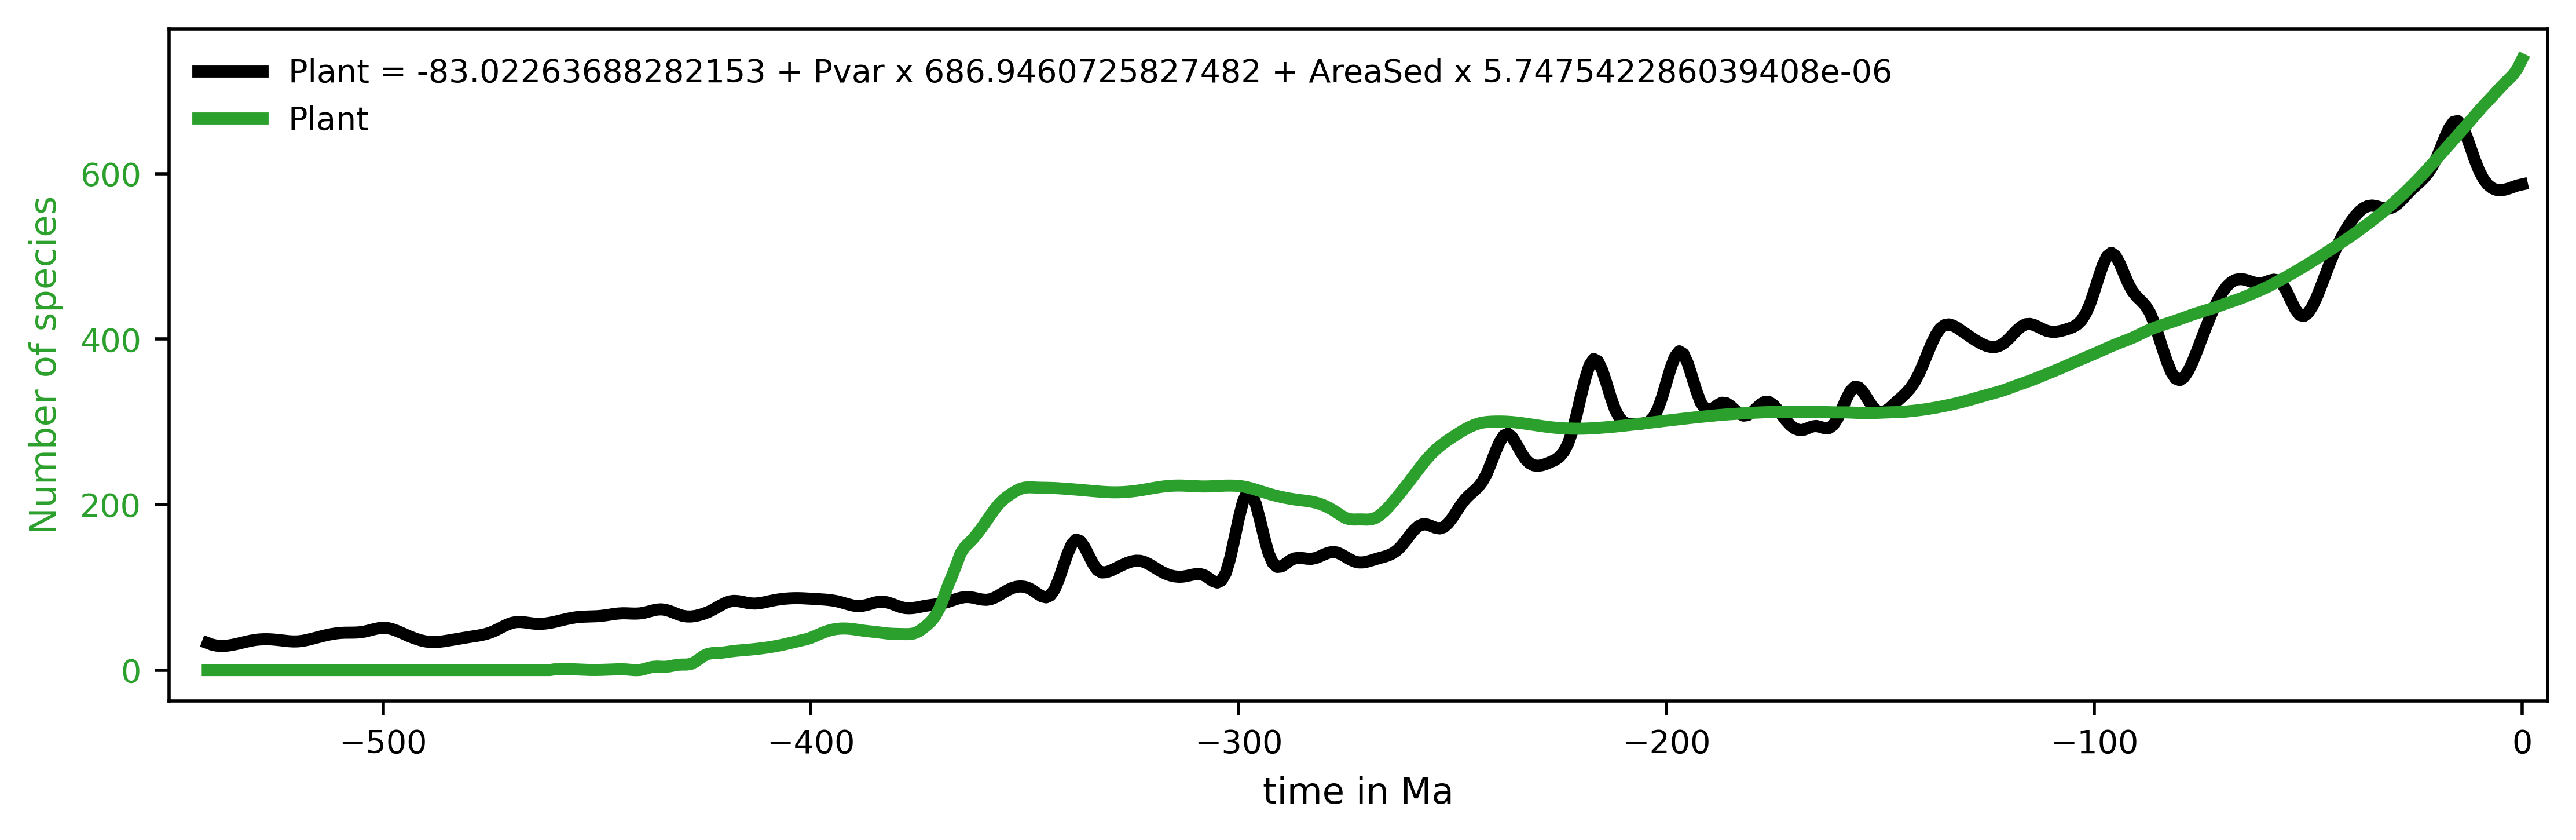

In [12]:
fig, ax1 = plt.subplots(figsize=(9, 3), dpi=500)


lbl1 = 'Plant = '+str(regr.intercept_)+' + Pvar x '+str(regr.coef_[0])+' + AreaSed x '+str(regr.coef_[1])

ax1.plot(df['time'], plantValues, '-', color='black', zorder=2, lw=3, label=lbl1)
ax1.plot(df['time'], df['Plant'], '-', color='tab:green', zorder=2, lw=3, label='Plant')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax1.tick_params(axis='y', labelcolor='tab:green')

plt.ylabel('Number of species', fontsize=9, color='tab:green')
plt.xlabel('time in Ma', fontsize=9)
plt.xlim([-550,6])

plt.legend(frameon=False, prop={'size': 8}, loc=0)

fig.tight_layout()
# plt.savefig('trend_erodeprate.png',dpi=500,transparent=True)
plt.show()

In [13]:
res = stats.pearsonr(plantValues, df['Plant'].values)

print('Pearson btw created function and plant value: ',res.statistic)

Pearson btw created function and plant value:  0.947061330078788


## Testing with normalised values

In [14]:
Pvar = df['Pvar'].values
Pvar = Pvar.reshape(-1, 1)
Pvar_norm = pre.MinMaxScaler().fit_transform(Pvar)

AreaSedcover = df['AreaSedCover'].values
AreaSedcover = AreaSedcover.reshape(-1, 1)
AreaSedcover_norm = pre.MinMaxScaler().fit_transform(AreaSedcover)

Plant = df['Plant'].values
Plant = Plant.reshape(-1, 1)
Plant_norm = pre.MinMaxScaler().fit_transform(Plant)

In [15]:
# initialize data of lists.
normdata = {'time': df['time'].values,
            'Plant': Plant_norm[:,0],
            'AreaSedCover': AreaSedcover_norm[:,0],
            'Pvar': Pvar_norm[:,0],
       }
normdf = pd.DataFrame(normdata)
normdf

,time,Plant,AreaSedCover,Pvar
0,-541.0,0.000210,0.000000,0.093064
1,-540.0,0.000210,0.000294,0.082898
2,-539.0,0.000210,0.000637,0.076510
3,-538.0,0.000210,0.001042,0.073322
4,-537.0,0.000210,0.001520,0.072754
...,...,...,...,...
537,-4.0,0.961698,0.944108,0.699611
538,-3.0,0.968371,0.937767,0.721433
539,-2.0,0.975816,0.928585,0.751273
540,-1.0,0.985778,0.915895,0.788414


In [16]:
nx = normdf[['Pvar','AreaSedCover']]
ny = normdf['Plant']

In [17]:
# with sklearn
nregr = linear_model.LinearRegression()

nregr.fit(nx, ny)

print('Intercept: \n', nregr.intercept_)
print('Coefficient Pvar: \n', nregr.coef_[0])
print('Coefficient AreaSedCover: \n', nregr.coef_[1])

plantnValues = nregr.intercept_ + normdf['Pvar'].values * nregr.coef_[0] + normdf['AreaSedCover'].values * nregr.coef_[1]

Intercept: 
 0.019152550421475567
Coefficient Pvar: 
 0.2720858839828134
Coefficient AreaSedCover: 
 0.6115866534665179


In [18]:
# with statsmodels
nx2 = sm.add_constant(nx) # adding a constant
 
nmodel = sm.OLS(ny, nx2).fit()
npredictions = model.predict(nx2) 

In [19]:
print_nmodel = nmodel.summary()
print(print_nmodel)

                            OLS Regression Results                            
Dep. Variable:                  Plant   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2345.
Date:                Thu, 14 Dec 2023   Prob (F-statistic):          1.11e-266
Time:                        08:51:33   Log-Likelihood:                 594.06
No. Observations:                 542   AIC:                            -1182.
Df Residuals:                     539   BIC:                            -1169.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0192      0.006      3.423   

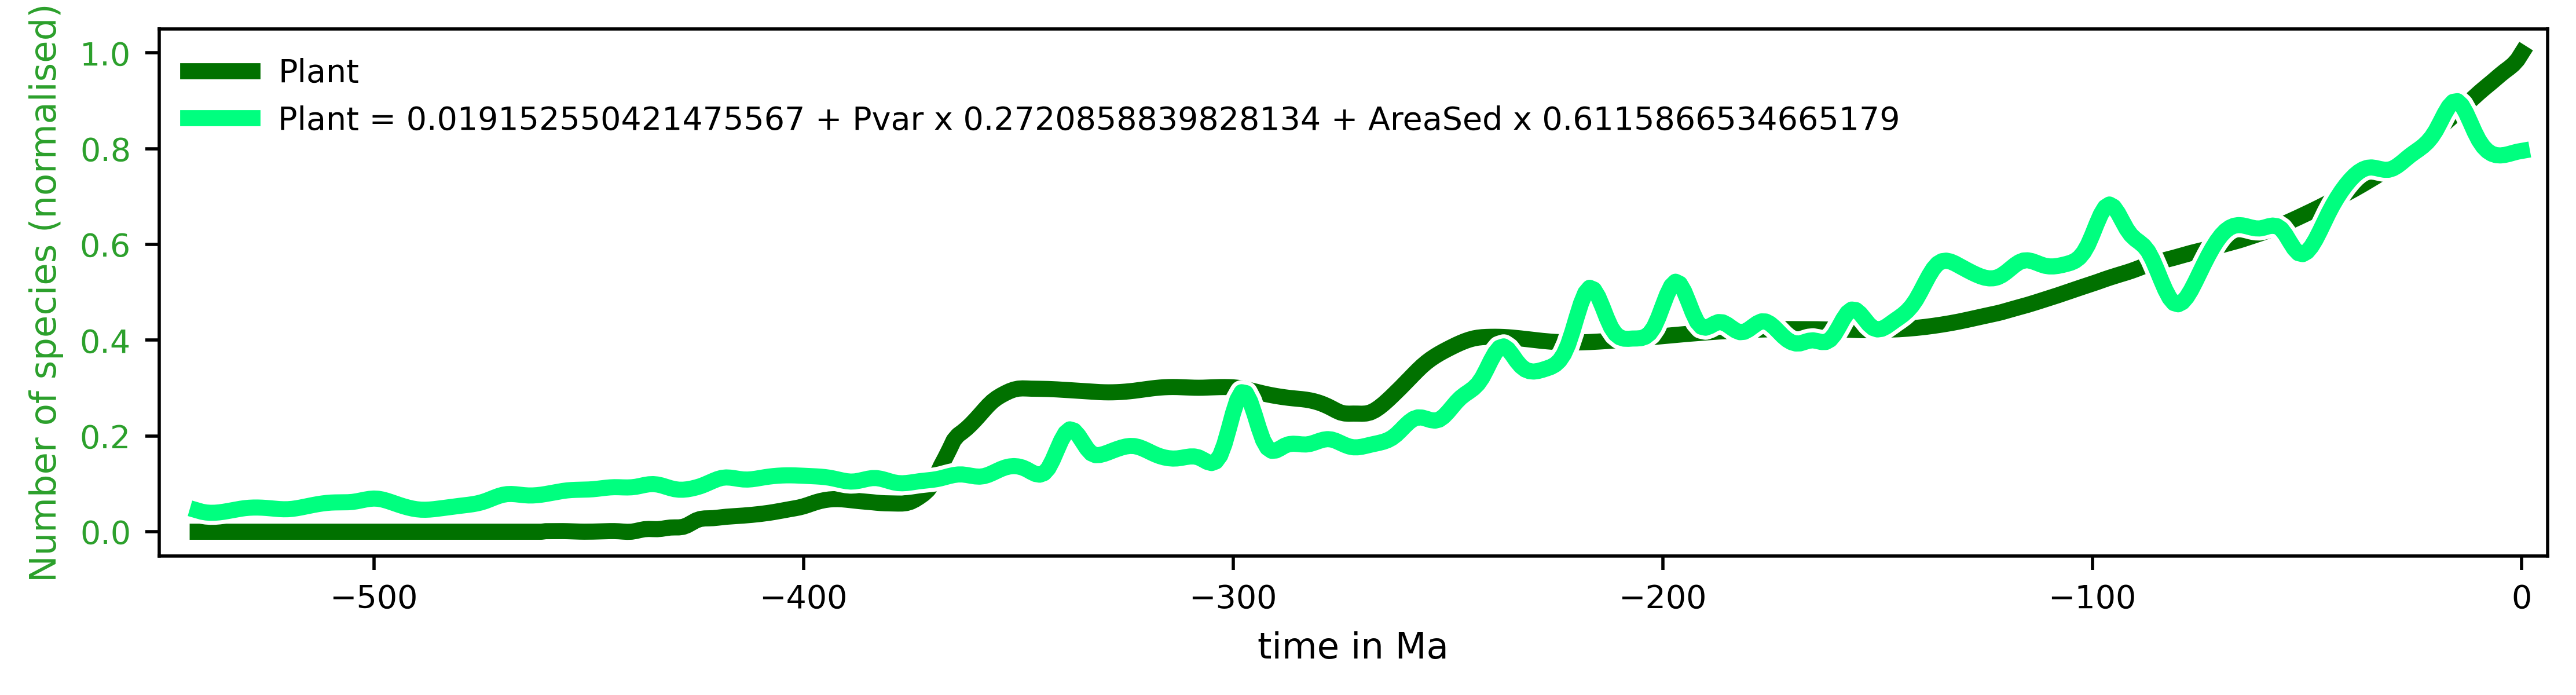

In [20]:
fig, ax1 = plt.subplots(figsize=(9, 2.5), dpi=500)


lbl1 = 'Plant = '+str(nregr.intercept_)+' + Pvar x '+str(nregr.coef_[0])+' + AreaSed x '+str(nregr.coef_[1])

ax1.plot(normdf['time'], normdf['Plant'], '-', color='#017100', zorder=2, lw=4, label='Plant')
ax1.plot(normdf['time'], plantnValues, '-', color='white', zorder=2, lw=6)
ax1.plot(normdf['time'], plantnValues, '-', color='springgreen', zorder=2, lw=4, label=lbl1)

# ax1.plot(areaSed['time'], areaSed['value'], '-', color='tab:red', zorder=2, lw=4, label='Erosion deposition rate')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax1.tick_params(axis='y', labelcolor='tab:green')

plt.ylabel('Number of species (normalised)', fontsize=9, color='tab:green')
plt.xlabel('time in Ma', fontsize=9)
plt.xlim([-550,6])

plt.legend(frameon=False, prop={'size': 8}, loc=0)

fig.tight_layout()
plt.savefig('function_plant.png',dpi=500,transparent=True)
plt.show()

In [21]:
nres = stats.pearsonr(plantnValues, normdf['Plant'].values)

print('Pearson btw created function and plant value: ',nres.statistic)

Pearson btw created function and plant value:  0.9470613300787882
